# Data Preprocessing and merging

This notebook contains gene variable homologation to human genes (preserving non-orthologous NMR genes) and QC filtering by finding the local minima. 

Finally it merges the NMR data with Human Data According to its region for cross-species cell-type annotation. 

### Pipeline

#### NMR

1) Load filtered data obtained from cellbender (add .obs[['region', 'species', 'replicate' , 'sample_id']])
2) Find mitochondrial and ribosomal genes
3) Calculate QC metrics (standard + log1p)
4) Set QC thresholds with `find_means.py` per region
5) QC Filtering
6) Map gene variables to homologus gene variables
7) Save counts layer
8) Save AnnData object per region

#### Human
0) Select and download relevant datasets (adult and developing brain)
1) Subsample around 300 cells per cell-type
2) Map gene variables to homologus gene variables
3) QC + Basic Filtering (use selected thresholds)
7) Save counts layer


#### Cross-species Dataset

1) Ensure there is no duplicated genes in nmr or human data (drop duplicated genes with less counts)
2) Normalization + log1p
3) Select HVGs
4) Merge Human and NMR datasets (how='outer, fillna = 0)
5) Save AnnData object per region

Available kernel & conda env: `scanpy-env`


In [96]:
# Revision number (change every time you run it again)
rev_n = 10
# File paths
path_to_nmr_input_dir = '/home/raquelcr/scanpy/ann_datasets/'
path_to_human_adult_data = '/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad'
path_to_human_orthology ='../orthology/nmr_human_orthology.csv'
path_to_human_cluster_ann = '../data/preprocessing/human_glossary.csv'
path_to_human_input_dir = '../../scanpy/data/human_data/'
path_to_output_dir = '../scanpy/results/preprocessing/'


In [98]:
import pandas as pd
cluster_ref = pd.read_csv(path_to_human_cluster_ann)


In [17]:
import os
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

KeyboardInterrupt: 

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Human dataset

Siletti, K., Hodge, R., Mossi Albiach, A., Lee, K. W., Ding, S.-L., Hu, L., Lönnerberg, P., Bakken, T., Casper, T., Clark, M., Dee, N., Gloe, J., Hirschstein, D., Shapovalova, N. V., Keene, C. D., Nyhus, J., Tung, H., Yanny, A. M., Arenas, E., … Linnarsson, S. (2023). **Transcriptomic diversity of cell types across the adult human brain.** Science, 382(6667), eadd7046. https://doi.org/10.1126/science.add7046

https://www.biorxiv.org/content/10.1101/2022.10.12.511898v1.full.pdf



In [ ]:
# Download if it doesn't exists
if os.path.exists(path_to_human_adult_data)!= True:
    !wget -O /home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad 'https://storage.googleapis.com/linnarsson-lab-human/human_adult_GRCh38-3.0.0.h5ad'
else:
    print("File already exists")

File already exists


In [ ]:
# must be 27G
!du -h path_to_human_adult_data

27G	/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad


In [ ]:
# Load gene otholog reference table (adapted with `gene_reference.ipynb`)
gene_reference = pd.read_csv(path_to_human_orthology)
gene_reference.head()

In [99]:
human_anot = pd.read_csv(path_to_human_cluster_ann)
human_anot.dropna(how='all',inplace=True)
human_anot['Cluster ID'] = [int(k) for k in human_anot['Cluster ID']]
human_anot.set_index('Cluster ID', inplace=True)
human_anot.sort_values('Number of cells', ascending=False)['Number of cells']

Cluster ID
47     124837
45     109325
44     101039
311     97038
49      84282
        ...  
75         70
29         63
408        45
314        42
297        34
Name: Number of cells, Length: 461, dtype: int64

### Sampling a reference human dataset

`human_aldult_GRCh38-3.0.0.h5ad` contains the gene expresssion matrix of 3,369,219 cells and 33,538 genes. In order to use it as a reference, we can sample a subset of the whole dataset to decrease computation resources needed to perform calculation. Only a fraction of randomly selected data is considered in this analysis and 34 cells per cluster were added to improve represtability of low number of cells clusters. 

In [13]:
# Stratified sampling to ensure all clusters are represented
# Takes around 10 minutes to run
def subsample_dataset(dataset_path,random_seed=71, fraction=0.05, min_per_cluster=34, filter_by=None):
    dirname = os.path.dirname(dataset_path)
    basename = os.path.basename(dataset_path)
    subset_path = os.path.join(dirname,f"{basename.split(r'[-.]')[0]}_subset{random_seed}.h5ad")

    if os.path.exists(subset_path):
        print("Loading existing subset...")
        human_data = sc.read(subset_path)
        print(f"Sampled dataset: {human_data.shape[0]} × {human_data.shape[1]}")
        return human_data
    else:
        print("Creating new subset...")

        # Step 1. Open dataset in backed mode
        adata_backed = sc.read_h5ad(dataset_path, backed="r")
        if filter_by != None:
            if filter_by in adata_backed.obs.columns:
                adata_backed = adata_backed[adata_backed.obs[filter_by].str.contains(r'[Cc]ortex|[Hh]ippocampus|[Mm]idbrain',regex=True)]
            else: return NameError(filter_by)

        n_cells = adata_backed.n_obs
        target_size = int(n_cells * fraction)
        print(f"Original: {n_cells} cells, target {target_size}")

        # Step 2. Get cluster info
        clusters = adata_backed.obs["cluster_id"].astype(str)

        np.random.seed(random_seed)
        sampled_indices = []
        summary = []  # collect stats

        # Step 3. Stratified sampling per cluster
        for clust, idx in clusters.groupby(clusters).groups.items():
            idx = np.array(list(idx))  # indices for this cluster
            n_total = len(idx)

            # desired sample = 5% + 34, but not more than available
            n_sample = int(n_total * fraction) + min_per_cluster
            n_sample = min(n_sample, n_total)

            chosen = np.random.choice(idx, size=n_sample, replace=False)
            sampled_indices.extend(chosen)

            summary.append([clust, n_total, n_sample])

        # Step 4. Load only sampled cells into memory
        human_data = sc.read_h5ad(dataset_path)[sampled_indices, :].copy()

        print(f"Final sampled dataset: {human_data.shape[0]} × {human_data.shape[1]}")

        # Step 5. Print per-cluster summary
        df_summary = pd.DataFrame(summary, columns=["cluster_id", "total_cells", "sampled_cells"])
        df_summary["fraction_sampled"] = df_summary["sampled_cells"] / df_summary["total_cells"]
        print(df_summary.sort_values("total_cells").head(20))  # show smallest clusters
        print("...")
        print(df_summary.sort_values("total_cells", ascending=False).head(20))  # show largest clusters

        # Step 6. Save the subset
        human_data.write_h5ad(subset_path)
        print(f"Sampled dataset saved to {subset_path}")
        return human_data


In [ ]:
human_data = subsample_dataset(path_to_human_adult_data
                               ,random_seed=2, fraction=0.03, min_per_cluster=20, filter_by='dissection')

Loading existing subset...
Only considering the two last: ['.h5ad_subset2', '.h5ad'].
Only considering the two last: ['.h5ad_subset2', '.h5ad'].
Sampled dataset: 6182 × 33538


In [100]:
human_data.obs['region']=None
human_data.obs.loc[human_data.obs['dissection'].str.contains(r'[Cc]ortex', regex=True), 'region'] = "cerebral cortex"
human_data.obs.loc[human_data.obs['dissection'].str.contains(r'[Hh]ippocampus', regex=True), 'region'] = "hippocampus"
human_data.obs.loc[human_data.obs['dissection'].str.contains(r'[Mm]idbrain', regex=True), 'region'] = "midbrain"

NameError: name 'human_data' is not defined

In [16]:
human_data.obs[['dissection', 'region']]

,dissection,region
CellID,,
10X393_3:CCACACTGTTCACGAT,Tail of Hippocampus (HiT) - Caudal Hippocampus...,hippocampus
10X229_8:TTACGCCAGACTTGTC,Head of hippocampus (HiH) - Uncal CA2-CA3,hippocampus
10X173_4:TGAACGTCACCAAAGG,Midbrain (M) - Inferior colliculus and nearby ...,midbrain
10X176_1:ACCATTTAGCACGATG,"Midbrain (M) - Substantia Nigra, Red Nucleus, ...",midbrain
10X225_2:CATGCGGCACAGTGTT,Midbrain (M) - Periaqueductal gray and nearby ...,midbrain
...,...,...
10X376_8:AGCCAATCAGCGTAGA,Cerebral cortex (Cx) - Inferior temporal gyrus...,cerebral cortex
10X384_6:GAACACTAGCCGCTTG,Cerebral cortex (Cx) - Occipitotemporal (fusif...,cerebral cortex
10X330_6:TCCTTCTCAACTGCCG,Cerebral cortex (Cx) - Subcallosal Gyrus (SCG)...,cerebral cortex


In [17]:
# See obtained cluster representation
human_data.obs['cluster_id'] = human_data.obs['cluster_id'].astype('category')
human_data.obs.groupby('cluster_id').count()['roi'].sort_values(ascending=False)

cluster_id
460    15
443    15
442    15
441    15
440    15
       ..
339     1
301     1
346     1
81      1
304     1
Name: roi, Length: 449, dtype: int64

In [18]:
human_data.obs.head(2)

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi,region
CellID,,,,,,,,,,,,,,,,
10X393_3:CCACACTGTTCACGAT,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,10X393_3,0,CA4C-DGC,hippocampus
10X229_8:TTACGCCAGACTTGTC,Head of hippocampus (HiH) - Uncal CA2-CA3,1391,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Head of hippocampus (HiH) - Uncal CA2-CA3,1391,10X229_8,0,CA2U-CA3U,hippocampus


In [ ]:
# Map human gene names to supercluster using human_anot
supercluster_map = dict(zip(human_anot['Cluster name'], human_anot['Supercluster']))
cluster_map = dict(zip(human_anot.index, human_anot['Cluster name']))
major_map = dict(zip(human_anot['Cluster name'], human_anot['Major Field']))
human_data.obs['cell_type'] = human_data.obs['cluster_id'].map(cluster_map)
human_data.obs['cell_supertype'] = human_data.obs['cell_type'].map(supercluster_map)

human_data.obs

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi,region,cell_type,species,cell_supertype
CellID,,,,,,,,,,,,,,,,,,,
10X393_3:CCACACTGTTCACGAT,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,10X393_3,0,CA4C-DGC,hippocampus,Bcell_0,human,Miscellaneous
10X229_8:TTACGCCAGACTTGTC,Head of hippocampus (HiH) - Uncal CA2-CA3,1391,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Head of hippocampus (HiH) - Uncal CA2-CA3,1391,10X229_8,0,CA2U-CA3U,hippocampus,Bcell_0,human,Miscellaneous
10X173_4:TGAACGTCACCAAAGG,Midbrain (M) - Inferior colliculus and nearby ...,2661,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Inferior colliculus and nearby ...,2661,10X173_4,0,IC,midbrain,Bcell_0,human,Miscellaneous
10X176_1:ACCATTTAGCACGATG,"Midbrain (M) - Substantia Nigra, Red Nucleus, ...",3114,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,"Midbrain (M) - Substantia Nigra, Red Nucleus, ...",3114,10X176_1,0,SN-RN,midbrain,Bcell_0,human,Miscellaneous
10X225_2:CATGCGGCACAGTGTT,Midbrain (M) - Periaqueductal gray and nearby ...,984,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Periaqueductal gray and nearby ...,984,10X225_2,0,PAG,midbrain,Bcell_0,human,Miscellaneous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X376_8:AGCCAATCAGCGTAGA,Cerebral cortex (Cx) - Inferior temporal gyrus...,29380,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000136,H19.30.001,nucleus,Cerebral cortex (Cx) - Inferior temporal gyrus...,29380,10X376_8,99,ITG,cerebral cortex,DLCT6b_99,human,Deep-layer corticothalamic and 6b
10X384_6:GAACACTAGCCGCTTG,Cerebral cortex (Cx) - Occipitotemporal (fusif...,16868,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000136,H19.30.001,nucleus,Cerebral cortex (Cx) - Occipitotemporal (fusif...,16868,10X384_6,99,TF,cerebral cortex,DLCT6b_99,human,Deep-layer corticothalamic and 6b
10X330_6:TCCTTCTCAACTGCCG,Cerebral cortex (Cx) - Subcallosal Gyrus (SCG)...,22442,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Cerebral cortex (Cx) - Subcallosal Gyrus (SCG)...,22442,10X330_6,99,A25,cerebral cortex,DLCT6b_99,human,Deep-layer corticothalamic and 6b


In [25]:
# Add species column
human_data.obs['species'] = 'human'
human_data.obs.head(2)

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi,region,cell_type,species,cell_supertype
CellID,,,,,,,,,,,,,,,,,,,
10X393_3:CCACACTGTTCACGAT,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,10X393_3,0,CA4C-DGC,hippocampus,Bcell_0,human,Miscellaneous
10X229_8:TTACGCCAGACTTGTC,Head of hippocampus (HiH) - Uncal CA2-CA3,1391,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Head of hippocampus (HiH) - Uncal CA2-CA3,1391,10X229_8,0,CA2U-CA3U,hippocampus,Bcell_0,human,Miscellaneous


In [26]:
human_data.var_names

Index(['ENSG00000237613', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000284733', 'ENSG00000284662',
       'ENSG00000225880', 'ENSG00000230368', 'ENSG00000223764',
       'ENSG00000188976',
       ...
       'ENSG00000228240', 'ENSG00000226906', 'ENSG00000183753',
       'ENSG00000205944', 'ENSG00000227439', 'ENSG00000235412',
       'ENSG00000183795', 'ENSG00000205916', 'ENSG00000172288',
       'ENSG00000231141'],
      dtype='object', name='Accession', length=33538)

In [27]:
gene_reference

,human_gene_name,human_gene_acc,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
0,A2M,ENSG00000175899,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
1,A3GALT2,ENSG00000184389,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7
2,A4GALT,ENSG00000128274,A4GALT,ENSHGLG00000048655,77.0538,ortholog_one2one,1.0,1.0,22,5
3,A4GNT,ENSG00000118017,A4GNT,ENSHGLG00000014457,79.3510,ortholog_one2one,1.0,1.0,3,8
4,AAAS,ENSG00000094914,AAAS,ENSHGLG00000002843,93.0147,ortholog_one2one,2.0,1.0,12,17
...,...,...,...,...,...,...,...,...,...,...
14976,TNFRSF11B,ENSG00000164761,TNFRSF11B,ENSHGLG00000004624,86.5337,ortholog_one2one,1.0,1.0,8,21
14977,TRAP1,ENSG00000126602,TRAP1,ENSHGLG00000010156,89.2045,ortholog_one2one,1.0,1.0,16,23
14978,VIP,ENSG00000146469,VIP,ENSHGLG00000003764,84.1176,ortholog_one2one,1.0,1.0,6,1
14979,ZNF689,ENSG00000156853,ZNF689,ENSHGLG00000009540,94.2000,ortholog_one2one,1.0,1.0,16,23


In [28]:
# Map human gene names to global names using gene_reference
human_gene_map = dict(zip(gene_reference['human_gene_acc'], gene_reference['human_gene_name']))
human_data.var['global_name'] = human_data.var_names.map(human_gene_map)


In [29]:
print(f"{str(human_data.var['global_name'].notna().sum())} out of {human_data.var.shape[0]} genes mapped to global names.")

14379 out of 33538 genes mapped to global names.


In [30]:
human_data.var[12:20]

,Chromosome,End,Gene,Start,Strand,global_name
Accession,,,,,,
ENSG00000188290,1,1000172,HES4,998962,-,NaN
ENSG00000224969,1,1013193,AL645608.2,1011997,-,NaN
ENSG00000273443,1,1063288,AL645608.9,1062208,-,NaN
ENSG00000237330,1,1074307,RNF223,1070966,-,RNF223
ENSG00000131591,1,1116361,C1orf159,1081818,-,C1orf159
ENSG00000205231,1,1179555,TTLL10-AS1,1173056,-,NaN
ENSG00000186891,1,1206691,TNFRSF18,1203508,-,TNFRSF18
ENSG00000186827,1,1214138,TNFRSF4,1211326,-,TNFRSF4


In [31]:
human_data.shape

(6182, 33538)

## Developing Human Brain

This dataset contains 1,665,937 cells, so it is recommended to subsample it.

Eze, U.C., Bhaduri, A., Haeussler, M. et al. Single-cell atlas of early human brain development highlights heterogeneity of human neuroepithelial cells and early radial glia. Nat Neurosci 24, 584–594 (2021). https://doi.org/10.1038/s41593-020-00794-1

https://assets.nemoarchive.org/dat-0rsydy7

File: scanpy/ann_datasets/human_dev.h5ad (Must be 12GB)


In [32]:
!du -h /home/raquelcr/scanpy/ann_datasets/human_dev.h5ad

12G	/home/raquelcr/scanpy/ann_datasets/human_dev.h5ad


In [33]:
dev_human = subsample_dataset('/home/raquelcr/scanpy/ann_datasets/human_dev.h5ad'
                               ,random_seed=2, fraction=0.05, min_per_cluster=20, filter_by='Region')

Loading existing subset...
Sampled dataset: 5705 × 59459


In [34]:
# Add species column
dev_human.obs['species'] = 'human'
dev_human.obs['region'] = None
dev_human.obs.loc[dev_human.obs['Region'].str.contains(r'[Cc]ortex', regex=True), 'region'] = "cerebral cortex"
dev_human.obs.loc[dev_human.obs['Region'].str.contains(r'[Hh]ippocampus', regex=True), 'region'] = "hippocampus"
dev_human.obs.loc[dev_human.obs['Region'].str.contains(r'[Mm]idbrain', regex=True), 'region'] = "midbrain"
dev_human.obs.head(4)

,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,...,cell_type_ontology_term_id,fraction_mitochondrial,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id,species,region
CellID,,,,,,,,,,,,,,,,,,,,,
10X122_8:TTATGCTAGGTGCAAC,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,CL:0000031,0.003380,0.349109,0.002459,1797,3254,10X122_8,0,human,midbrain
10X122_7:TCTTCGGAGGTTACCT,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,CL:0000031,0.008454,0.315048,0.007139,2624,5323,10X122_7,0,human,midbrain
10X122_7:ACCCACTAGAAGATTC,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,CL:0000031,0.016073,0.295672,0.002228,2820,6284,10X122_7,0,human,midbrain
10X122_7:CCCAGTTCAGCGTTCG,6.9,Radial glia,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,CL:0000681,0.016281,0.288108,0.003067,2314,4238,10X122_7,1,human,midbrain


In [35]:
dev2humananot = {
    # Células del Linaje Neuronal
    "Neuroblast": "DLNP_83",  # Neuroblastos son progenitores neuronales. DLNP (Deep Layer Neuronal Progenitor) es un buen representante.
    "Neuronal IPC": "DLIT_136",  # IPC (Intermediate Progenitor Cell). DLIT (Deep Layer Inhibitory Neuron) como un destino específico de un IPC neuronal.
    "Neuron": "L5ET_113",  # Neurona. L5ET (Layer 5 Excitatory Neuron) es un tipo principal de neurona cortical.

    # Células Gliales y Progenitoras
    "Radial glia": "Bgl_51",  # Glía Radial. Bgl (Bergmann Glia) es un tipo de glía radial en el cerebelo, o podemos usar Astro_52 como un subtipo diferenciado (los astrocitos son descendientes de la glía radial).
    "Glioblast": "Astro_52",  # Glioblastos son progenitores gliales, que dan lugar a astrocitos y oligodendrocitos. Astro_52 (Astrocito) es un linaje directo.
    "Oligo": "Oligo_40",  # Oligodendrocito. Oligo_40 es un subtipo de oligodendrocito maduro.

    # Células Inmunes
    "Immune": "Mgl_4",  # Inmune. Mgl (Microglia) es el principal tipo de célula inmune residente del SNC.

    # Células Vasculares y Asociadas
    "Vascular": "VendPLVAP_13",  # Vascular. Vend (Vascular Endothelial cell), la célula endotelial vascular con un marcador específico (PLVAP).

    # Células de Soporte No Neuronales / No Gliales
    "Fibroblast": "Fbl_24",  # Fibroblasto. Fbl (Fibroblast) con una especificación de subtipo.
    "Erythrocyte": "Misc_116",  # Eritrocito. A menudo agrupados en células "Misceláneas" o "Hematopoyéticas" en scRNA-seq de cerebro, ya que no son residentes.

    # Linajes Embrionarios
    "Neural crest": "Per_21",  # Cresta Neural. Algunas células de la cresta neural migran al SNC y dan lugar a Pericitos (Per), que son células murales vasculares.
    "Placodes": "Chrp_76"  # Placodes. Chrp (Choroid Plexus) son epitelios especializados con orígenes neuroectodermales, que podrían ser un representante funcional en un conjunto de datos adulto/desarrollo tardío.
}

In [36]:
dev_human.obs['cell_type'] = dev_human.obs['CellClass'].map(dev2humananot)
dev_human.obs['cell_supertype'] = dev_human.obs['cell_type'].map(supercluster_map)

dev_human.obs

,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,...,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id,species,region,cell_type,cell_supertype
CellID,,,,,,,,,,,,,,,,,,,,,
10X122_8:TTATGCTAGGTGCAAC,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.349109,0.002459,1797,3254,10X122_8,0,human,midbrain,DLNP_83,Deep-layer near-projecting
10X122_7:TCTTCGGAGGTTACCT,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.315048,0.007139,2624,5323,10X122_7,0,human,midbrain,DLNP_83,Deep-layer near-projecting
10X122_7:ACCCACTAGAAGATTC,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.295672,0.002228,2820,6284,10X122_7,0,human,midbrain,DLNP_83,Deep-layer near-projecting
10X122_7:CCCAGTTCAGCGTTCG,6.9,Radial glia,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.288108,0.003067,2314,4238,10X122_7,1,human,midbrain,Bgl_51,Bergmann glia
10X251_8:TGCACGGCAAATACAG,14.0,Glioblast,v3,Midbrain,Midbrain dorsal,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,unknown,...,0.390315,0.001110,3050,7207,10X251_8,10,human,midbrain,Astro_52,Astrocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X89_7:CGTGTAACAAGAAAGG,8.0,Radial glia,v2,Midbrain,Midbrain ventral,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.151450,0.001074,645,931,10X89_7,99,human,midbrain,Bgl_51,Bergmann glia
10X126_3:CCAGCGATCAAACGGG,6.9,Radial glia,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.121484,0.003591,1726,3342,10X126_3,99,human,midbrain,Bgl_51,Bergmann glia
10X298_7:CGAGTGCGTTCTCCCA,5.5,Radial glia,v3,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,unknown,...,0.189673,0.004391,2595,5694,10X298_7,99,human,midbrain,Bgl_51,Bergmann glia


In [37]:
# Find mito_genes
dev_human.var['mt'] = dev_human.var['Gene'].str.startswith('MT-')
print(f'Found {str(dev_human.var["mt"].sum())} mito genes')

Found 37 mito genes


In [38]:
gene_reference.head(2)

,human_gene_name,human_gene_acc,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
0,A2M,ENSG00000175899,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
1,A3GALT2,ENSG00000184389,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7


In [39]:
# Drop last part of the Accession to match gene_reference 
dev_human.var['Accession'] = [acc.split('.')[0] if pd.notna(acc) else acc for acc in dev_human.var['Accession']]
dev_human.var

,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,mt
Accession,,,,,,,
ENSG00000223972.5,ENSG00000223972,chr1,14409,3,11869,DDX11L1,False
ENSG00000227232.5,ENSG00000227232,chr1,29570,104073,14404,WASH7P,False
ENSG00000278267.1,ENSG00000278267,chr1,17436,0,17369,MIR6859-1,False
ENSG00000284332.1,ENSG00000284332,chr1,30503,0,30366,MIR1302-2,False
ENSG00000268020.3,ENSG00000268020,chr1,53312,0,52473,OR4G4P,False
...,...,...,...,...,...,...,...
ENSG00000275757.1,ENSG00000275757,chr22_KI270733v1,174108,0,173956,5_8S_rRNA-8,False
ENSG00000278573.1,ENSG00000278573,chr22_KI270734v1,60316,0,59711,AC007325.3,False
ENSG00000276017.1,ENSG00000276017,chr22_KI270734v1,74814,15,72411,AC007325.1,False


In [40]:
dev_human.var['global_name'] = dev_human.var['Accession'].map(human_gene_map)
dev_human.var['global_name'].notnull().sum() # must not be 0 or near 0

np.int64(14930)

In [41]:
dev_human.var_names = dev_human.var['global_name']
dev_human.var.sort_values('GeneTotalUMIs', ascending=False).head(15)

,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,mt,global_name
global_name,,,,,,,,
NaN,ENSG00000251562,chr11,65506516,419535869,65497688,MALAT1,False,NaN
TUBA1A,ENSG00000167552,chr12,49189080,82872215,49184795,TUBA1A,False,TUBA1A
NaN,ENSG00000210082,chrM,3229,54470313,1671,MT-RNR2,True,NaN
MT-CO1,ENSG00000198804,chrM,7445,50031188,5904,MT-CO1,True,MT-CO1
NaN,ENSG00000147403,chrX,154409168,47190036,154389955,RPL10,False,NaN
ACTG1,ENSG00000184009,chr17,81523847,46167199,81509971,ACTG1,False,ACTG1
TMSB10,ENSG00000034510,chr2,84906671,45385699,84905656,TMSB10,False,TMSB10
NaN,ENSG00000205542,chrX,12977227,45256038,12975110,TMSB4X,False,NaN
MT-CO3,ENSG00000198938,chrM,9990,45054217,9207,MT-CO3,True,MT-CO3


In [42]:
# drop genes without global name
dev_human = dev_human[:, dev_human.var['global_name'].notna()].copy()
dev_human.var_names_make_unique()

In [43]:
dev_human

AnnData object with n_obs × n_vars = 5705 × 14930
    obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'species', 'region', 'cell_type', 'cell_supertype'
    var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 'Gene', 'mt', 'global_name'
    uns: 'batch_condition', 'title'
    obsm: 'Factors', 'X_Embedding'
    varm: 'Loadings'

## Naked Mole Rat Datasets

In [44]:
nmr_files = glob.glob('/home/raquelcr/scanpy/cellbender/denoised/*_filtered.h5')
nmr_files

['/home/raquelcr/scanpy/cellbender/denoised/NMR2_cerebral_cortex_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR1_cerebral_cortex_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR3_hippocampus_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR4_hippocampus_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR5_midbrain_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR6_midbrain_denoised_filtered.h5']

In [45]:
# Load gene otholog reference table (adapted with `gene_reference.ipynb`)
gene_reference = pd.read_csv('/home/raquelcr/NMR-snRNA-seq/orthology/nmr_human_orthology.csv')
gene_reference.head()

,human_gene_name,human_gene_acc,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
0,A2M,ENSG00000175899,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
1,A3GALT2,ENSG00000184389,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7
2,A4GALT,ENSG00000128274,A4GALT,ENSHGLG00000048655,77.0538,ortholog_one2one,1.0,1.0,22,5
3,A4GNT,ENSG00000118017,A4GNT,ENSHGLG00000014457,79.3510,ortholog_one2one,1.0,1.0,3,8
4,AAAS,ENSG00000094914,AAAS,ENSHGLG00000002843,93.0147,ortholog_one2one,2.0,1.0,12,17


In [46]:
gene_reference

,human_gene_name,human_gene_acc,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
0,A2M,ENSG00000175899,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
1,A3GALT2,ENSG00000184389,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7
2,A4GALT,ENSG00000128274,A4GALT,ENSHGLG00000048655,77.0538,ortholog_one2one,1.0,1.0,22,5
3,A4GNT,ENSG00000118017,A4GNT,ENSHGLG00000014457,79.3510,ortholog_one2one,1.0,1.0,3,8
4,AAAS,ENSG00000094914,AAAS,ENSHGLG00000002843,93.0147,ortholog_one2one,2.0,1.0,12,17
...,...,...,...,...,...,...,...,...,...,...
14976,TNFRSF11B,ENSG00000164761,TNFRSF11B,ENSHGLG00000004624,86.5337,ortholog_one2one,1.0,1.0,8,21
14977,TRAP1,ENSG00000126602,TRAP1,ENSHGLG00000010156,89.2045,ortholog_one2one,1.0,1.0,16,23
14978,VIP,ENSG00000146469,VIP,ENSHGLG00000003764,84.1176,ortholog_one2one,1.0,1.0,6,1
14979,ZNF689,ENSG00000156853,ZNF689,ENSHGLG00000009540,94.2000,ortholog_one2one,1.0,1.0,16,23


In [47]:
nmr_adatas = []
nmr_gene_map = dict(zip(gene_reference['nmr_gene_acc'], gene_reference['human_gene_name']))
nmr_gene_chr_map = dict(zip(gene_reference['nmr_gene_acc'],gene_reference['nmr_chr']))

for file in nmr_files:
    # CellBender output should be read with read_10x_h5
    try: 
        adata = sc.read_10x_h5(file)
    except:
        adata = sc.read(file)

    adata.var['species'] = 'nmr'

    sample = file.replace('/home/raquelcr/scanpy/cellbender/denoised/NMR', '').replace('_denoised_filtered.h5', '').split('_', 1)
    sample_id = sample[0]
    tissue = sample[1]

    print(f'Loading sample {sample_id} of {tissue}')

    adata.obs['species'] = 'nmr'
    adata.obs['tissue'] = tissue
    adata.obs['sample_id'] = sample_id
    adata.obs['replicate'] = (int(sample_id)+1)%2+1

    # Map NMR gene IDs to global names
    adata.var['genome'] = 'HetGla_female1'
    adata.var['chromosome'] = adata.var['gene_ids'].map(nmr_gene_chr_map)
    adata.var['global_name'] = adata.var['gene_ids'].map(nmr_gene_map)
    adata.var['global_name'].fillna(pd.Series(adata.var.index, index=adata.var.index), inplace=True)
    nmr_adatas.append(adata)

nmr_adatas

Loading sample 2 of cerebral_cortex
Loading sample 1 of cerebral_cortex
Loading sample 3 of hippocampus
Loading sample 4 of hippocampus
Loading sample 5 of midbrain
Loading sample 6 of midbrain


[AnnData object with n_obs × n_vars = 19487 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'chromosome', 'global_name',
 AnnData object with n_obs × n_vars = 14268 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'chromosome', 'global_name',
 AnnData object with n_obs × n_vars = 6743 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'chromosome', 'global_name',
 AnnData object with n_obs × n_vars = 8179 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'chromosome', 'global_name',
 AnnData object with n_obs × n_vars = 7369 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'chromosome', 'global_name',
 AnnData object wi

In [48]:
nmr_adatas[0].var[nmr_adatas[0].var['global_name'].isna()]

,gene_ids,feature_types,genome,species,chromosome,global_name


In [49]:
for ad in nmr_adatas:
    if 'global_name' not in ad.var.columns:
        ad.var['global_name'] = ad.var.index
    ad.var_names_make_unique()

In [50]:
nmr_data = sc.concat(nmr_adatas,axis=0, join='outer', label='sample', keys=[os.path.basename(f).replace('_denoised_filtered.h5', '').split('_',1)[0] for f in nmr_files], index_unique='-')
nmr_data.shape

(66126, 20774)

In [51]:
nmr_data.obs['region'] = None
nmr_data.obs.loc[nmr_data.obs['tissue'].str.contains(r'[Cc]ortex', regex=True), 'region'] = "cerebral cortex"
nmr_data.obs.loc[nmr_data.obs['tissue'].str.contains(r'[Hh]ippocampus', regex=True), 'region'] = "hippocampus"
nmr_data.obs.loc[nmr_data.obs['tissue'].str.contains(r'[Mm]idbrain', regex=True), 'region'] = "midbrain"
nmr_data.obs.head(4)

,species,tissue,sample_id,replicate,sample,region
TCGCTTGGTCATCCCT-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex
AACAACCCACAAGCCC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex
ACGTACAGTGATGGCA-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex
TTCCACGAGCACCGTC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex


In [52]:
ref_var = nmr_adatas[0].var
nmr_data.var = nmr_data.var.combine_first(ref_var)


In [53]:
nmr_data.var

,chromosome,feature_types,gene_ids,genome,global_name,species
ZMYND10,8,Gene Expression,ENSHGLG00000010267,HetGla_female1,ZMYND10,nmr
AMIGO3,NaN,Gene Expression,ENSHGLG00000010542,HetGla_female1,AMIGO3,nmr
TNFSF10,NaN,Gene Expression,ENSHGLG00000010558,HetGla_female1,TNFSF10,nmr
ENSHGLG00000010617,NaN,Gene Expression,ENSHGLG00000010617,HetGla_female1,ENSHGLG00000010617,nmr
NPRL2,8,Gene Expression,ENSHGLG00000010655,HetGla_female1,NPRL2,nmr
...,...,...,...,...,...,...
ENSHGLG00000000459,NaN,Gene Expression,ENSHGLG00000000459,HetGla_female1,ENSHGLG00000000459,nmr
ENSHGLG00000000069,NaN,Gene Expression,ENSHGLG00000000069,HetGla_female1,ENSHGLG00000000069,nmr
ENSHGLG00000019630,NaN,Gene Expression,ENSHGLG00000019630,HetGla_female1,ENSHGLG00000019630,nmr
ENSHGLG00000019772,NaN,Gene Expression,ENSHGLG00000019772,HetGla_female1,ENSHGLG00000019772,nmr


In [54]:
## Save NMR data
filename = f'/home/raquelcr/scanpy/ann_datasets/nmr_adatas{rev_n}.h5ad'
nmr_data.write_h5ad(filename)
print(f"AnnData object successfully saved to {filename}")

AnnData object successfully saved to /home/raquelcr/scanpy/ann_datasets/nmr_adatas9.h5ad


## Check individual QC metrics

In [63]:
nmr_mito_genes = open('/home/raquelcr/scanpy/nmr_mito_genes.txt', 'r').read().splitlines()
nmr_mito_genes

['ND1',
 'ND2',
 'COX1',
 'COX2',
 'ATP8',
 'ATP6',
 'COX3',
 'ND3',
 'ND4L',
 'ND4',
 'ND5',
 'ND6',
 'CYTB']

In [64]:
human_ribo_genes = pd.read_csv('/home/raquelcr/scanpy/human_ribo_genes.csv', header=1)
human_ribo_genes = human_ribo_genes['Approved symbol'].tolist()
len(human_ribo_genes)

247

In [65]:
for adata in [human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    if 'mt' not in nmr_data.var.columns:
        try: adata.var["mt"] = adata.var['Chromosome'] == 'MT'
        except: adata.var["mt"] = adata.var_names.str.startswith(("mt-", "MT-","Mt-")) |[gene in nmr_mito_genes for gene in adata.var_names]
    print(f'Found {adata.var["mt"].sum()} mito genes.')
    # ribosomal genes
    try: adata.var["ribo"] = [name in human_ribo_genes for name in adata.var['Gene']]
    except: adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL", "Rpl", "Rps"))
    print(f'Found {adata.var["ribo"].sum()} ribo genes.\n')
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True)

human
Found 13 mito genes.
Found 171 ribo genes.

nmr
Found 13 mito genes.
Found 78 ribo genes.

human
Found 11 mito genes.
Found 120 ribo genes.



human


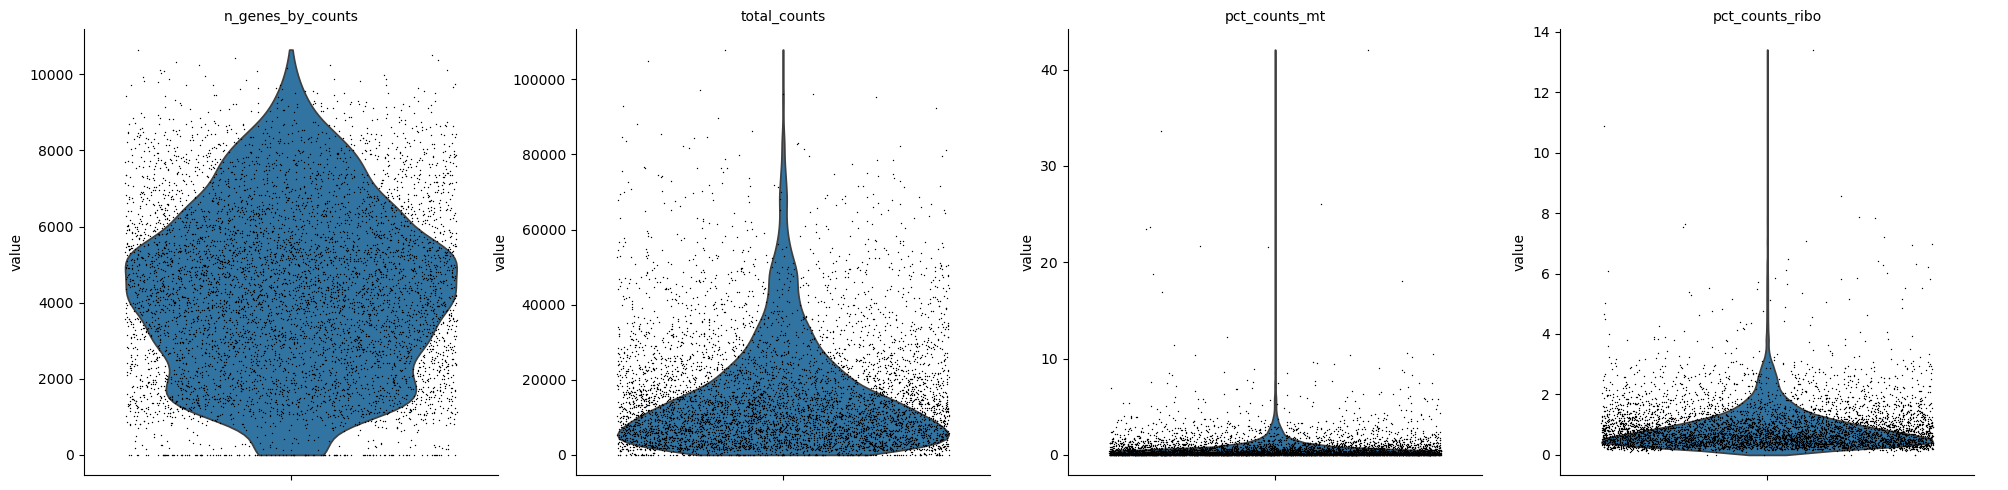

nmr


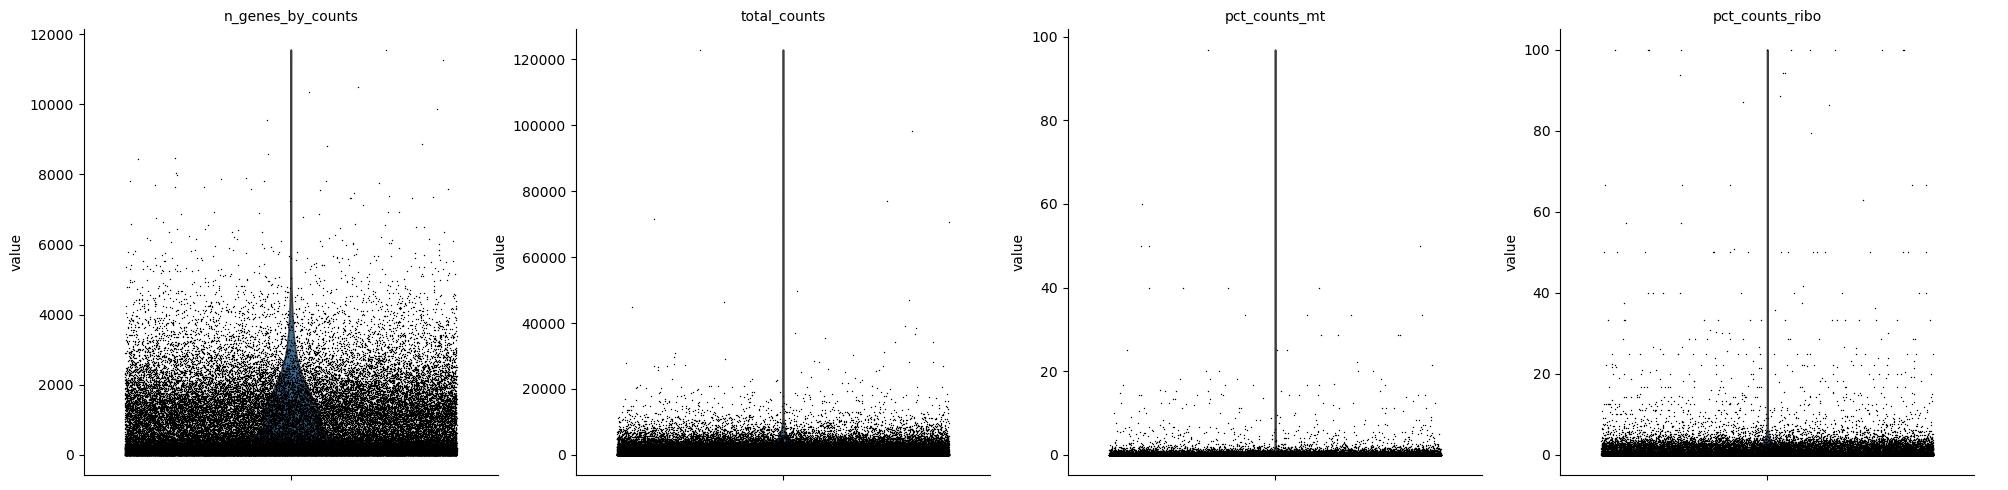

human


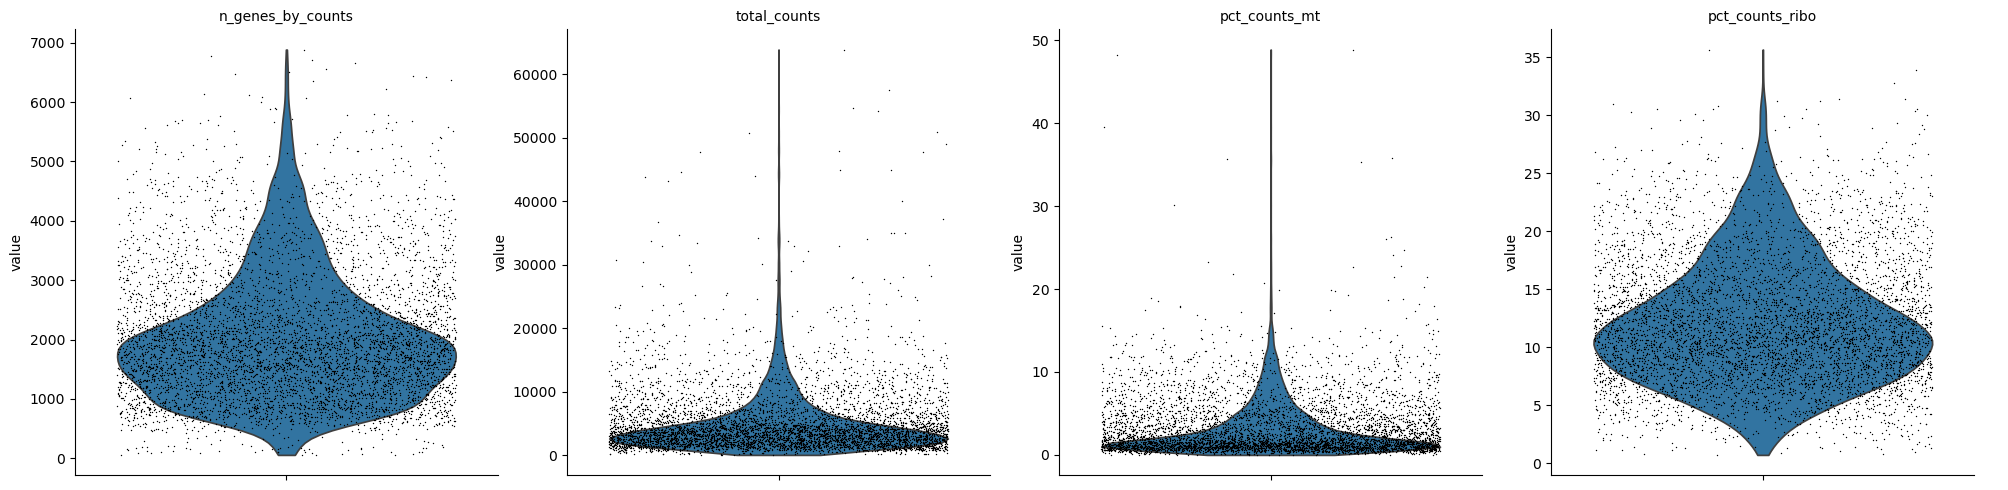

In [66]:
for adata in [human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
        jitter=0.4,
        multi_panel=True,
    )

In [68]:
nmr_data.obs

,species,tissue,sample_id,replicate,sample,region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo
TCGCTTGGTCATCCCT-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,8820,9.084891,44836.0,10.710789,7.801766,12.142029,18.491837,31.813721,46.0,3.850148,0.102596,378.0,5.937536,0.843073
AACAACCCACAAGCCC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,7324,8.899048,28299.0,10.250617,9.138132,14.095904,21.032545,34.683204,16.0,2.833213,0.056539,142.0,4.962845,0.501785
ACGTACAGTGATGGCA-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,7688,8.947546,27593.0,10.225354,8.353568,12.861958,19.472330,32.432139,35.0,3.583519,0.126844,220.0,5.398163,0.797304
TTCCACGAGCACCGTC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,7574,8.932609,27076.0,10.206440,8.151130,12.483380,19.005762,32.024671,28.0,3.367296,0.103413,253.0,5.537334,0.934407
CAGATACGTATTGGCT-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,6932,8.844048,25839.0,10.159679,12.097991,17.713534,24.946786,38.314176,25.0,3.258097,0.096753,135.0,4.912655,0.522466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATTCTACATAGTCGT-1-NMR6,nmr,midbrain,6,2,NMR6,midbrain,5,1.791759,31.0,3.465736,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
GACATCATCATGAGTC-1-NMR6,nmr,midbrain,6,2,NMR6,midbrain,3,1.386294,24.0,3.218876,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
TTGTGGATCTGGGCGT-1-NMR6,nmr,midbrain,6,2,NMR6,midbrain,1,0.693147,27.0,3.332205,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
TGGTACATCCGGACGT-1-NMR6,nmr,midbrain,6,2,NMR6,midbrain,6,1.945910,26.0,3.295837,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [69]:
# See cells that will be droped out by a basic filtering
print('n_genes_by_counts <= 30:\n',nmr_data.obs[nmr_data.obs['n_genes_by_counts']<=30].value_counts('sample'))
print('\nlog1p_total_counts <= 4:\n',nmr_data.obs[nmr_data.obs['log1p_total_counts']<=4].value_counts('sample'))
print('\nlog1p_total_counts > 10:\n',nmr_data.obs[nmr_data.obs['log1p_total_counts']>10].value_counts('sample'))
print('\npct_counts_mt > 5 :\n',nmr_data.obs[nmr_data.obs['pct_counts_mt']>5].value_counts('sample'))
print('\npct_counts_ribo > 7 :\n',nmr_data.obs[nmr_data.obs['pct_counts_ribo']>7].value_counts('sample'))



n_genes_by_counts <= 30:
 sample
NMR6    5298
NMR5    2342
NMR2     107
NMR3      63
NMR1       0
NMR4       0
Name: count, dtype: int64

log1p_total_counts <= 4:
 sample
NMR6    5636
NMR5    2816
NMR2     204
NMR3      77
NMR1       0
NMR4       0
Name: count, dtype: int64

log1p_total_counts > 10:
 sample
NMR3    30
NMR4     9
NMR2     8
NMR1     1
NMR5     0
NMR6     0
Name: count, dtype: int64

pct_counts_mt > 5 :
 sample
NMR5    112
NMR6     68
NMR1      3
NMR2      2
NMR3      2
NMR4      1
Name: count, dtype: int64

pct_counts_ribo > 7 :
 sample
NMR6    331
NMR5    318
NMR1      3
NMR4      2
NMR2      1
NMR3      1
Name: count, dtype: int64


In [70]:
# Filter out low-quality cells in human data
human_data = human_data[human_data.obs['log1p_total_counts'] > 4,:]
human_data = human_data[human_data.obs['log1p_total_counts'] < 10,:]
human_data = human_data[human_data.obs['pct_counts_mt'] < 5,:]
human_data = human_data[human_data.obs['pct_counts_ribo'] < 7,:]
human_data.shape

(4496, 33538)

In [71]:
# Filter out low-quality cells in nmr data
nmr_data = nmr_data[nmr_data.obs['log1p_total_counts'] > 4,:]
nmr_data = nmr_data[nmr_data.obs['log1p_total_counts'] < 10,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_mt'] < 3,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_ribo'] < 7,:]
nmr_data.shape

(57171, 20774)

In [72]:
# Filter out low-quality cells in human dev data
dev_human = dev_human[dev_human.obs['log1p_total_counts'] > 4,:]
dev_human = dev_human[dev_human.obs['log1p_total_counts'] < 10,:]
dev_human = dev_human[dev_human.obs['pct_counts_mt'] < 5,:]
dev_human = dev_human[dev_human.obs['pct_counts_ribo'] < 7,:]
dev_human.shape

(690, 14930)

human


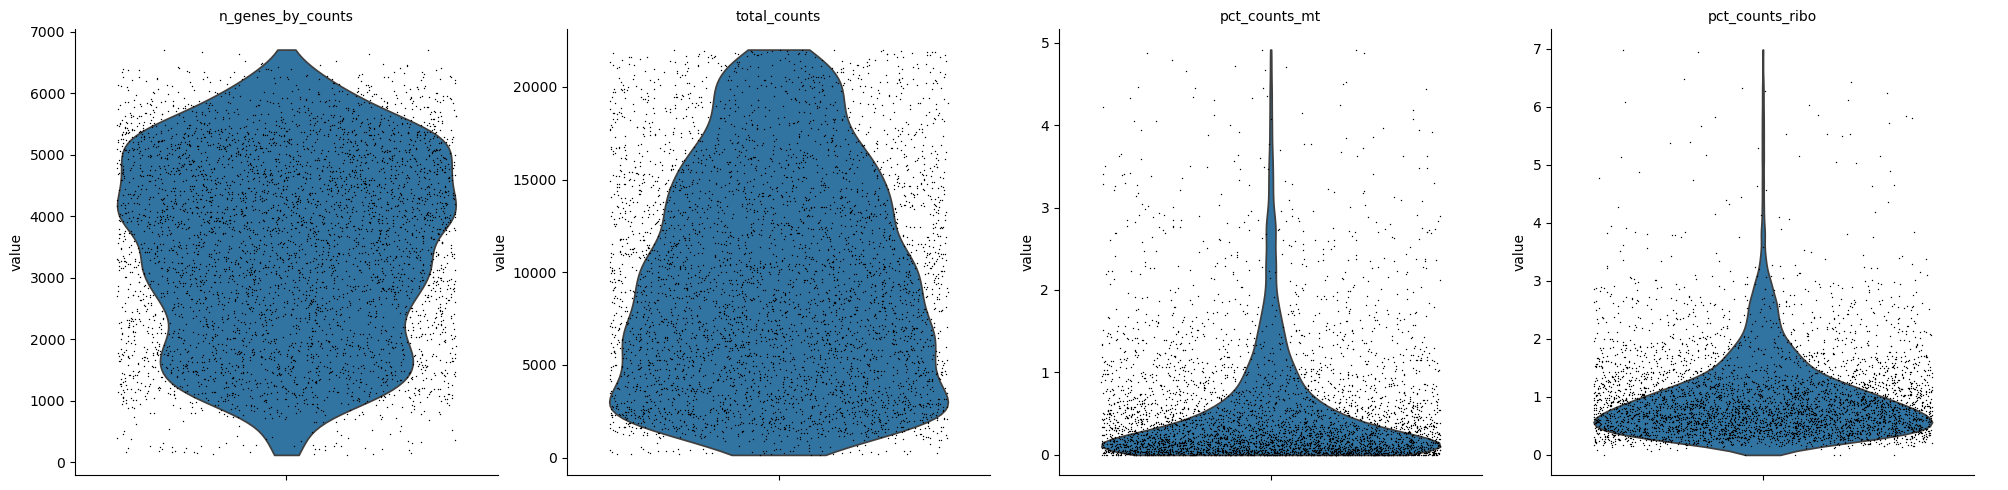

nmr


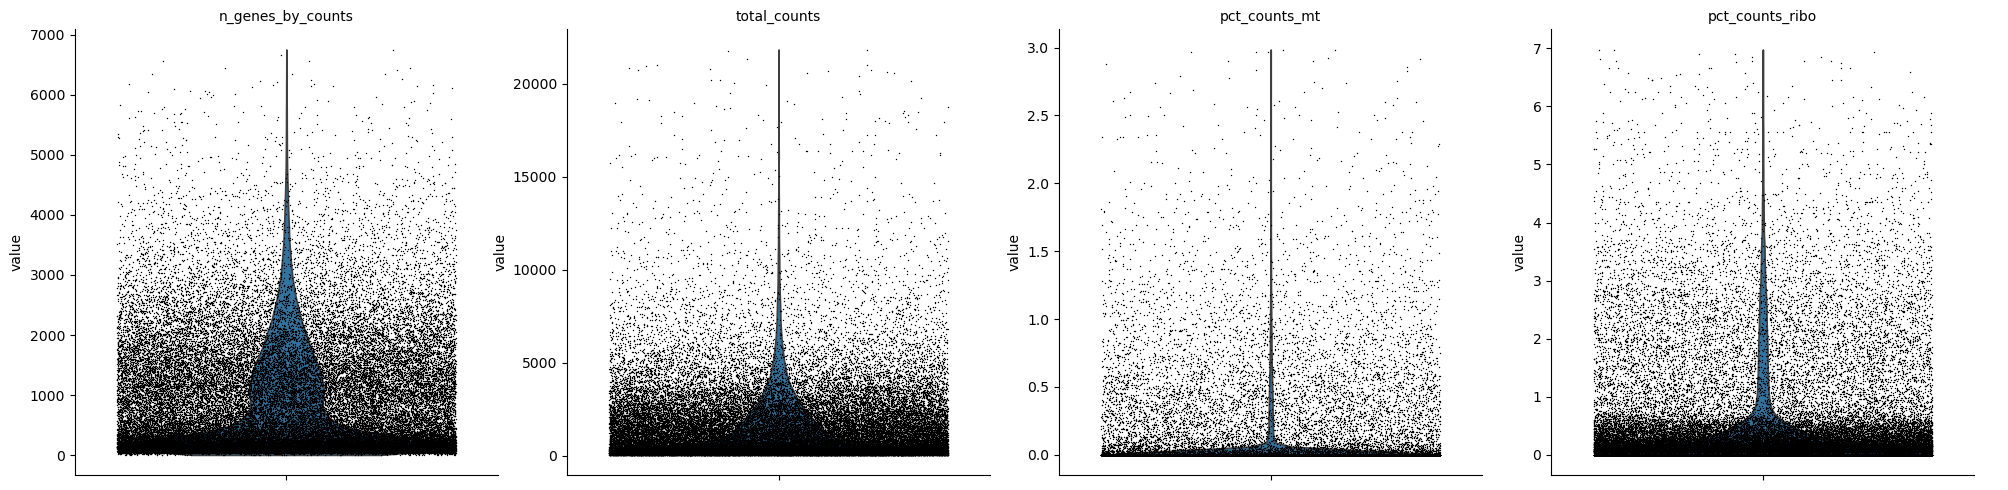

human


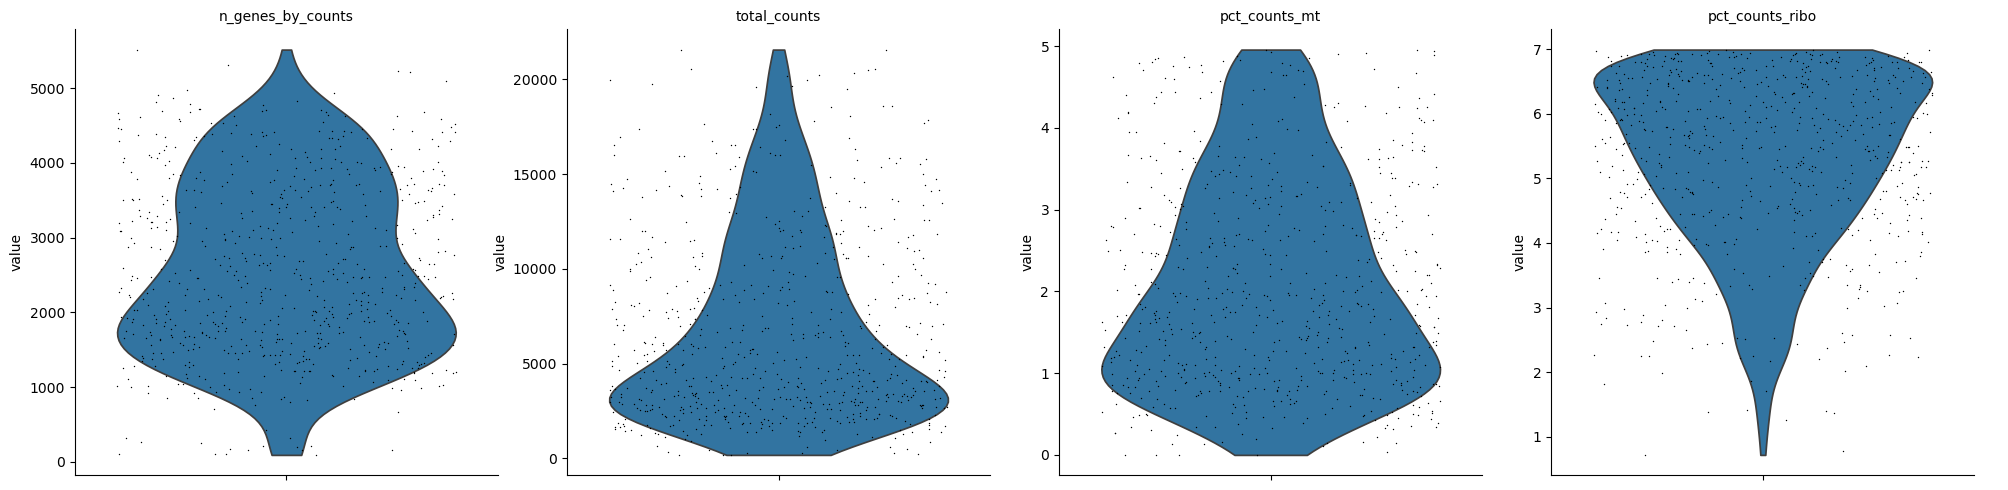

In [73]:
for adata in [human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
        jitter=0.4,
        multi_panel=True,
    )

In [74]:
# Save a temporal copy just in case
hu = human_data.copy()
nm = nmr_data.copy()
dh = dev_human.copy()


In [75]:
# Run to go back to this checkpoint
human_data,nmr_data, dev_human = (hu,nm,dh)

## Subset each dataset.var by only shared genes by at least 2 species

In [76]:
# Find intersection of global_name across all datasets
human_genes = set(human_data.var['global_name'].dropna())
nmr_genes = set(nmr_data.var['global_name'].dropna())

shared_genes = human_genes & nmr_genes
any_shared_genes = (human_genes & nmr_genes)
print(f"Number of genes shared by at least two species: {len(any_shared_genes)}")


Number of genes shared by at least two species: 13337


In [77]:
# Subset each dataset to shared global_name genes
human_data_shared = human_data[:, human_data.var['global_name'].isin(any_shared_genes)]
nmr_data_shared = nmr_data[:, nmr_data.var['global_name'].isin(any_shared_genes)]
dev_human_shared = dev_human[:, dev_human.var['global_name'].isin(any_shared_genes)]

In [78]:
# reorder columns to match
shared_genes_sorted = sorted(any_shared_genes)
human_data_shared = human_data_shared[:, human_data_shared.var['global_name'].isin(shared_genes_sorted)]
nmr_data_shared = nmr_data_shared[:, nmr_data_shared.var['global_name'].isin(shared_genes_sorted)]
dev_human_shared = dev_human[:, dev_human.var['global_name'].isin(shared_genes_sorted)]

## Merge datasets from different species

- Correct var_names

- Delete duplicated gene names with lower counts

In [79]:
adata_list = [human_data_shared, nmr_data_shared, dev_human_shared]
for i, ad in enumerate(adata_list):
    print(f"adata {i} var_names head:\n", ad.var_names[:10],'\n')


adata 0 var_names head:
 Index(['ENSG00000188976', 'ENSG00000237330', 'ENSG00000131591',
       'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808',
       'ENSG00000184163', 'ENSG00000160087', 'ENSG00000127054',
       'ENSG00000107404'],
      dtype='object', name='Accession') 

adata 1 var_names head:
 Index(['ZMYND10', 'AMIGO3', 'TNFSF10', 'NPRL2', 'GMPPB', 'NCEH1', 'IQCF2',
       'PIK3CB', 'BDH1', 'KLHL40'],
      dtype='object') 

adata 2 var_names head:
 Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'ISG15', 'RNF223', 'C1orf159',
       'TTLL10', 'TNFRSF18', 'TNFRSF4'],
      dtype='object', name='global_name') 



In [80]:
# Setting global_name as var_names for each dataset
for ad in adata_list:
    if "global_name" in ad.var.columns:
        ad.var_names = ad.var["global_name"].astype(str)

In [81]:
# Now see how var_names ended up
for i, ad in enumerate(adata_list):
    print(f"adata {i} var_names head:\n", ad.var_names[:10],'\n')

adata 0 var_names head:
 Index(['NOC2L', 'RNF223', 'C1orf159', 'TNFRSF18', 'TNFRSF4', 'SDF4',
       'C1QTNF12', 'UBE2J2', 'INTS11', 'DVL1'],
      dtype='object', name='global_name') 

adata 1 var_names head:
 Index(['ZMYND10', 'AMIGO3', 'TNFSF10', 'NPRL2', 'GMPPB', 'NCEH1', 'IQCF2',
       'PIK3CB', 'BDH1', 'KLHL40'],
      dtype='object', name='global_name') 

adata 2 var_names head:
 Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'ISG15', 'RNF223', 'C1orf159',
       'TTLL10', 'TNFRSF18', 'TNFRSF4'],
      dtype='object', name='global_name') 



In [82]:
# Check for duplicated genes before merging
human_duplicates = human_data_shared.var['global_name'][human_data_shared.var['global_name'].duplicated()]
print('Human adult duplicates:',human_duplicates)

nmr_duplicates = nmr_data_shared.var['global_name'][nmr_data_shared.var['global_name'].duplicated()]
print('NMR duplicates:',nmr_duplicates)

dev_human_duplicates = dev_human_shared.var['global_name'][dev_human_shared.var['global_name'].duplicated()]
print('Developing Human duplicates:',dev_human_duplicates)

Human adult duplicates: Series([], Name: global_name, dtype: category
Categories (13337, object): ['A1CF', 'A2M', 'A3GALT2', 'A4GALT', ..., 'ZXDC', 'ZYX', 'ZZEF1', 'ZZZ3'])
NMR duplicates: global_name
VTI1B      VTI1B
ARID3C    ARID3C
GMPS        GMPS
NRAP        NRAP
CYCS        CYCS
           ...  
PREP        PREP
BRCC3      BRCC3
MTCP1      MTCP1
ELK1        ELK1
DTWD1      DTWD1
Name: global_name, Length: 136, dtype: category
Categories (13337, object): ['A1CF', 'A2M', 'A3GALT2', 'A4GALT', ..., 'ZXDC', 'ZYX', 'ZZEF1', 'ZZZ3']
Developing Human duplicates: global_name
PLCXD1    PLCXD1
SHOX        SHOX
ASMTL      ASMTL
ASMT        ASMT
DHRSX      DHRSX
IL9R        IL9R
Name: global_name, dtype: category
Categories (13325, object): ['A1CF', 'A2M', 'A3GALT2', 'A4GALT', ..., 'ZXDC', 'ZYX', 'ZZEF1', 'ZZZ3']


In [83]:
human_data_shared.var[human_data_shared.var['global_name'].isin(human_duplicates.values)]

,Chromosome,End,Gene,Start,Strand,global_name,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
global_name,,,,,,,,,,,,,,


In [84]:
nmr_data_shared.var[nmr_data_shared.var['global_name'].isin(nmr_duplicates.values)]

,chromosome,feature_types,gene_ids,genome,global_name,species,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
global_name,,,,,,,,,,,,,,
RBP1,NaN,Gene Expression,ENSHGLG00000011860,HetGla_female1,RBP1,nmr,False,False,671,0.011781,0.011712,98.985271,779.0,6.659294
SI,NaN,Gene Expression,ENSHGLG00000014830,HetGla_female1,SI,nmr,False,False,533,0.008454,0.008418,99.193963,559.0,6.327937
OPA1,NaN,Gene Expression,ENSHGLG00000017084,HetGla_female1,OPA1,nmr,False,False,8691,0.177298,0.163222,86.856910,11724.0,9.369479
GMPS,NaN,Gene Expression,ENSHGLG00000019482,HetGla_female1,GMPS,nmr,False,False,4866,0.087772,0.084131,92.641321,5804.0,8.666475
CCR10,8,Gene Expression,ENSHGLG00000021074,HetGla_female1,CCR10,nmr,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BRCC3,NaN,Gene Expression,ENSHGLG00000001061,HetGla_female1,BRCC3,nmr,False,False,3609,0.062683,0.060797,94.542238,4145.0,8.329899
MTCP1,X,Gene Expression,ENSHGLG00000001243,HetGla_female1,MTCP1,nmr,False,False,843,0.013338,0.013250,98.725161,882.0,6.783325
MTCP1,NaN,Gene Expression,ENSHGLG00000001263,HetGla_female1,MTCP1,nmr,False,False,97,0.001467,0.001466,99.853310,97.0,4.584967


In [85]:
dev_human_shared.var[dev_human_shared.var['global_name'].isin(dev_human_duplicates.values)]


,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,mt,global_name,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
global_name,,,,,,,,,,,,,,,
PLCXD1,ENSG00000182378,chrX,303356,3614,276322,PLCXD1,False,PLCXD1,False,10,0.001753,0.001751,99.824715,10.0,2.397895
SHOX,ENSG00000185960,chrX,659411,1564,624344,SHOX,False,SHOX,False,9,0.001578,0.001576,99.842244,9.0,2.302585
ASMTL,ENSG00000169093,chrX,1453762,3697,1403139,ASMTL,False,ASMTL,False,14,0.002454,0.002451,99.754601,14.0,2.708050
ASMT,ENSG00000196433,chrX,1643081,573,1615059,ASMT,False,ASMT,False,2,0.000351,0.000351,99.964943,2.0,1.098612
DHRSX,ENSG00000169084,chrX,2502805,13734,2219506,DHRSX,False,DHRSX,False,35,0.006661,0.006639,99.386503,38.0,3.663562
IL9R,ENSG00000124334,chrX,156010817,0,155997581,IL9R,False,IL9R,False,0,0.000000,0.000000,100.000000,0.0,0.000000
PLCXD1,ENSG00000182378,chrY,303356,2040,276322,PLCXD1-1,False,PLCXD1,False,3,0.000526,0.000526,99.947415,3.0,1.386294
SHOX,ENSG00000185960,chrY,659411,1586,624344,SHOX-1,False,SHOX,False,10,0.001928,0.001926,99.824715,11.0,2.484907
ASMTL,ENSG00000169093,chrY,1453762,4548,1403139,ASMTL-1,False,ASMTL,False,18,0.003330,0.003325,99.684487,19.0,2.995732


In [86]:
from scipy import sparse

def drop_lower_count_duplicates(adata, gene_key="global_name", verbose=True):
    """
    Remove duplicated genes by keeping the one with highest global expression.
    Prints info about duplicates if verbose=True.
    
    Parameters
    ----------
    adata : AnnData
    gene_key : str
        Column in `adata.var` to identify gene names (default "global_name").
    verbose : bool
        If True, print duplicate genes and their counts.
    
    Returns
    -------
    AnnData with unique genes
    """
    # Get gene names
    if gene_key in adata.var.columns:
        genes = adata.var[gene_key].astype(str)
    else:
        genes = adata.var_names.astype(str)

    # Compute total counts per gene (sparse-aware)
    if sparse.issparse(adata.X):
        total_counts = np.array(adata.X.sum(axis=0)).flatten()
    else:
        total_counts = adata.X.sum(axis=0)

    # Build dataframe
    df = pd.DataFrame({
        "gene": genes.values,
        "total_counts": total_counts,
        "idx": np.arange(len(genes))
    })

    # Find duplicates
    dupes = df[df.duplicated("gene", keep=False)].sort_values("gene")

    if verbose and not dupes.empty:
        print("\nDuplicate genes found:")
        for g, sub in dupes.groupby("gene"):
            print(f"  {g}:")
            for _, row in sub.iterrows():
                print(f"    idx={row['idx']} total_counts={row['total_counts']}")
    
    # Keep max count per gene
    keep_idx = df.loc[df.groupby("gene")["total_counts"].idxmax(), "idx"].values

    # Subset AnnData
    adata_unique = adata[:, keep_idx].copy()
    adata_unique.var_names = genes.iloc[keep_idx].values

    return adata_unique


In [87]:
human_clean = drop_lower_count_duplicates(human_data_shared, gene_key="global_name")

print("Before:", human_data_shared.shape)
print("After:", human_clean.shape)

Before: (4496, 13337)
After: (4496, 13337)


In [88]:
nmr_clean = drop_lower_count_duplicates(nmr_data_shared, gene_key="global_name")
print("Before:", nmr_data_shared.shape)
print("After:", nmr_clean.shape)


Duplicate genes found:
  AKAP7:
    idx=4117 total_counts=103.0
    idx=4132 total_counts=3047.0
  AMD1:
    idx=13005 total_counts=5637.0
    idx=11376 total_counts=55.0
  AMN:
    idx=13351 total_counts=805.0
    idx=1302 total_counts=587.0
  APPL2:
    idx=9481 total_counts=9803.0
    idx=3464 total_counts=1729.0
  AR:
    idx=7217 total_counts=1485.0
    idx=12244 total_counts=863.0
  ARG1:
    idx=4136 total_counts=1540.0
    idx=5645 total_counts=104.0
  ARID3C:
    idx=1433 total_counts=1102.0
    idx=1416 total_counts=380.0
  ASIP:
    idx=9426 total_counts=21572.0
    idx=11302 total_counts=124.0
  ATL2:
    idx=10851 total_counts=7.0
    idx=1942 total_counts=7598.0
  B3GNT8:
    idx=12971 total_counts=6.0
    idx=12982 total_counts=2833.0
  BGLAP:
    idx=12342 total_counts=3472.0
    idx=12326 total_counts=2188.0
  BNC1:
    idx=12086 total_counts=153595.0
    idx=6248 total_counts=16.0
  BRCC3:
    idx=9478 total_counts=1834.0
    idx=13407 total_counts=4058.0
  BRI3:
   

In [89]:
dev_human_clean = drop_lower_count_duplicates(dev_human_shared, gene_key="global_name")

print("Before:", dev_human_shared.shape)
print("After:", dev_human_clean.shape)


Duplicate genes found:
  ASMT:
    idx=12885 total_counts=1.0
    idx=13316 total_counts=0.0
  ASMTL:
    idx=12884 total_counts=5.0
    idx=13315 total_counts=4.0
  DHRSX:
    idx=12886 total_counts=11.0
    idx=13317 total_counts=13.0
  IL9R:
    idx=13312 total_counts=0.0
    idx=13319 total_counts=0.0
  PLCXD1:
    idx=12882 total_counts=2.0
    idx=13313 total_counts=0.0
  SHOX:
    idx=12883 total_counts=3.0
    idx=13314 total_counts=1.0
Before: (690, 13331)
After: (690, 13325)


In [90]:
outer_merged = sc.concat(
    [nmr_clean, human_clean, dev_human_clean],
    join="outer", 
    merge="same",
    label="dataset_name",
    keys=["nmr", "human", "human_dev"],
    fill_value=0
)

print("Merged AnnData (outer):", outer_merged.shape)

Merged AnnData (outer): (62357, 13337)


In [91]:
outer_merged.obs['dataset_name'].value_counts()

dataset_name
nmr          57171
human         4496
human_dev      690
Name: count, dtype: int64

In [92]:
## CHECKPOINT
filename = f'/home/raquelcr/scanpy/all_adata_outer{rev_n}.h5ad'
outer_merged.write_h5ad(filename)
print(f"AnnData object successfully saved to {filename}")

AnnData object successfully saved to /home/raquelcr/scanpy/all_adata_outer9.h5ad


In [93]:
#outer_merged = sc.read(filename)

In [94]:
outer_merged.obs

,species,tissue,sample_id,replicate,sample,region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,...,Region,Subregion,tissue_type,tissue_ontology_term_id,cell_type_ontology_term_id,fraction_mitochondrial,fraction_unspliced,cell_cycle_score,total_genes,dataset_name
GGGTGAATCTAGCCAA-1-NMR2,nmr,cerebral_cortex,2,2.0,NMR2,cerebral cortex,5960,8.692994,20770.0,9.941313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
AAAGGGCAGTTTGGCT-1-NMR2,nmr,cerebral_cortex,2,2.0,NMR2,cerebral cortex,6181,8.729397,20742.0,9.939964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
CAGAGCCGTAGATGTA-1-NMR2,nmr,cerebral_cortex,2,2.0,NMR2,cerebral cortex,6553,8.787831,20638.0,9.934938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
GCACATACACCTCTGT-1-NMR2,nmr,cerebral_cortex,2,2.0,NMR2,cerebral cortex,6150,8.724370,19594.0,9.883030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
ATCGGCGAGGGACACT-1-NMR2,nmr,cerebral_cortex,2,2.0,NMR2,cerebral cortex,6166,8.726968,17961.0,9.796014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X185_4:ACTATCTCATACCACA,human,NaN,10X185_4,NaN,NaN,midbrain,4295,8.365440,12739.0,9.452502,...,Midbrain,Midbrain,tissue,UBERON:0001891,CL:0000030,0.030652,0.178238,0.028688,5915,human_dev
10X167_5:ATATCCTTCTAAACGC,human,NaN,10X167_5,NaN,NaN,midbrain,4207,8.344743,12021.0,9.394493,...,Midbrain,Midbrain,tissue,UBERON:0001891,CL:0000681,0.036532,0.457321,0.029943,5747,human_dev
10X122_7:TTCTACAAGTGAAGTT,human,NaN,10X122_7,NaN,NaN,midbrain,2143,7.670429,4004.0,8.295299,...,Midbrain,Midbrain,tissue,UBERON:0001891,CL:0000681,0.004536,0.382160,0.001848,2979,human_dev
10X122_7:CCTTCCCGTCTAGTGT,human,NaN,10X122_7,NaN,NaN,midbrain,2480,7.816417,4978.0,8.512984,...,Midbrain,Midbrain,tissue,UBERON:0001891,CL:0000681,0.007069,0.296881,0.038808,3399,human_dev
